In [2]:
%load_ext autoreload
%autoreload 2
import sys
import os
module_path = os.path.abspath(os.path.join('/data/jiawei_li/doubtbot')) 
if module_path not in sys.path:
    sys.path.append(module_path)
from data import load_data, transform_to_question_answer_pair
from eval import run_critic_eval
from model_wrappers import Llama2Wrapper, Llama3Wrapper

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
train_data, test_data = load_data()
sample = transform_to_question_answer_pair(train_data[:100])

In [4]:
# critic = Llama2Wrapper("llama2_7b", "meta-llama/Llama-2-7b-chat-hf")
critic = judge = Llama3Wrapper(
    "llama3_8b", "/data/public_models/huggingface/meta-llama/Meta-Llama-3-8B-Instruct"
)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [5]:
result_path = "/data/jiawei_li/doubtbot/data/results.json"
run_critic_eval(critic, judge, train_data[:100], result_path)

  0%|          | 0/100 [00:00<?, ?it/s]The attention mask is not set and cannot be inferred from input because pad token is same as eos token.As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)
100%|██████████| 100/100 [17:53<00:00, 10.73s/it]


In [6]:
import json
def print_entry(file_path, i=0):
    with open(file_path, 'r') as file:
        data = json.load(file)
        if i < 0 or i >= len(data):
            print(f"Index {i} is out of range for the JSON data.")
            return
        ith_entry = data[i]
        json_str = json.dumps(ith_entry, indent=4)
        for line in json_str.split('\n'):
            print(line)         

In [7]:
print_entry(result_path, 2)

{
    "question_answer_pair": {
        "question": "Betty is saving money for a new wallet which costs $100. Betty has only half of the money she needs. Her parents decided to give her $15 for that purpose, and her grandparents twice as much as her parents. How much more money does Betty need to buy the wallet?",
        "answer_correct": {
            "numeric": 5.0,
            "proof": "In the beginning, Betty has only 100 / 2 = $50.\nBetty's grandparents gave her 15 * 2 = $30.\nThis means, Betty needs 100 - 50 - 30 - 15 = $5 more.\n#### 5"
        },
        "answer_incorrect": {
            "numeric": 20.0,
            "proof": "In the beginning, Betty has only 100 / 2 = $50.\nBetty's grandparents gave her 15 * 2 = $30.\nThis means, Betty needs 100 - 50 - 30 = $20 more.\n#### 20"
        }
    },
    "critic": "llama3_8b",
    "judge": "llama3_8b",
    "critique": "The given answer claims that Betty needs $5 more to buy the wallet, but the proof is flawed and doesn't accurately a

In [8]:
def extract_confidence_pairs(json_file_path):
    with open(json_file_path, 'r') as file:
        data = json.load(file)
    
    confidence_pairs = []
    
    for entry in data:
        pre_critique = entry.get("judge_confidence_pre_critique")
        post_critique = entry.get("judge_confidence_post_critique")
        
        if pre_critique is not None and post_critique is not None:
            confidence_pairs.append((pre_critique, post_critique))
    
    return confidence_pairs

In [9]:
confidence_pairs = extract_confidence_pairs(result_path)

In [10]:
len(confidence_pairs)

100

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Convert to a DataFrame
df = pd.DataFrame(confidence_pairs, columns=['pre-critique', 'post-critique'])

# Calculate statistical metrics
metrics = df.describe()

# Display statistical metrics
print("Statistical Metrics:")
print(metrics)


Statistical Metrics:
       pre-critique  post-critique
count    100.000000     100.000000
mean       0.994771       0.293755
std        0.008130       0.275794
min        0.925875       0.004932
25%        0.994638       0.080769
50%        0.996721       0.193682
75%        0.997837       0.431309
max        0.999174       0.998577


In [12]:
k = 3
df['decrease'] = df['pre-critique'] - df['post-critique']

# Top k lowest decrease
lowest_decrease_indices = df.nsmallest(k, 'decrease').index.tolist()
print(f"Top {k} indices with the lowest decrease: {lowest_decrease_indices}")

# Top k highest decrease
highest_decrease_indices = df.nlargest(k, 'decrease').index.tolist()
print(f"Top {k} indices with the highest decrease: {highest_decrease_indices}")

Top 3 indices with the lowest decrease: [88, 45, 12]
Top 3 indices with the highest decrease: [9, 34, 99]


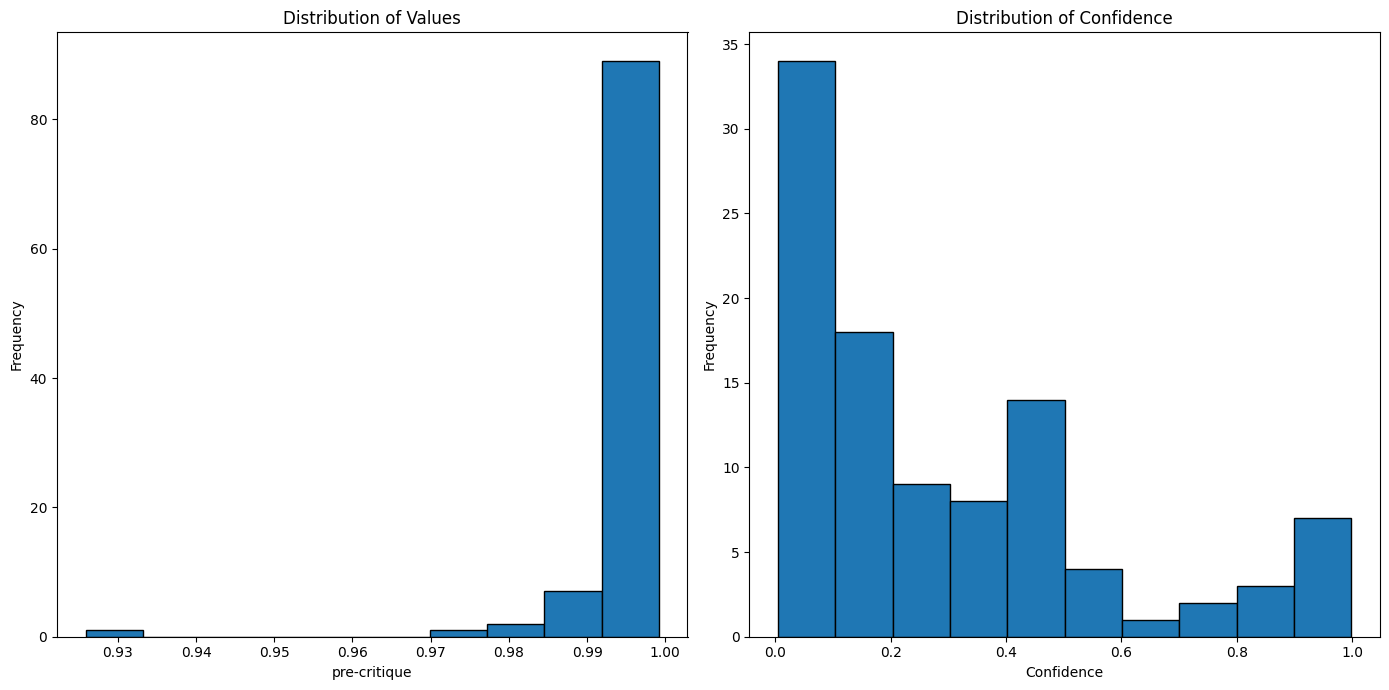

In [13]:
# Visualize the distribution
plt.figure(figsize=(14, 7))

# Value distribution
plt.subplot(1, 2, 1)
plt.hist(df['pre-critique'], bins=10, edgecolor='black')
plt.title('Distribution of Values')
plt.xlabel('pre-critique')
plt.ylabel('Frequency')

# Confidence distribution
plt.subplot(1, 2, 2)
plt.hist(df['post-critique'], bins=10, edgecolor='black')
plt.title('Distribution of Confidence')
plt.xlabel('Confidence')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [16]:
print("lowest decrease")
print_entry(result_path, 88)

lowest decrease
{
    "question_answer_pair": {
        "question": "Brandon sold 86 geckos last year. He sold twice that many the year before. How many geckos has Brandon sold in the last two years?",
        "answer_correct": {
            "numeric": 258.0,
            "proof": "Last year: 86 geckos\n2 years ago: 86(2)=172\nTotal number of geckos sold 86+172=258 geckos\n#### 258"
        },
        "answer_incorrect": {
            "numeric": -86.0,
            "proof": "Last year: 86 geckos\n2 years ago: 86(2)=172\nTotal number of geckos sold 86-172=-86 geckos\n#### -86"
        }
    },
    "critic": "llama3_8b",
    "judge": "llama3_8b",
    "critique": "The given answer, 258, is incorrect due to a fundamental mistake in the calculation. The problem states that Brandon sold twice as many geckos the year before, which means we need to multiply the number of geckos sold last year by 2, not add it.\n\nThe correct calculation should be:\n\nLast year: 86 geckos\n2 years ago: 86 x 2 = 1

In [17]:
print_entry(result_path, 45)

{
    "question_answer_pair": {
        "question": "It's Ava's birthday party. Her parents bought a unicorn pi\u00f1ata for $13 and filled it with all of her favorite treats. They bought 4 bags of Reese's for $9 per bag, 3 bags of Snickers for $5 per bag, and 5 bags of Skittles for $7 per bag. How much did the unicorn pi\u00f1ata and the treats cost altogether?",
        "answer_correct": {
            "numeric": 99.0,
            "proof": "The four bags of Reese's cost $9 x 4 = $36.\nThe three bags of Snickers cost $5 x 3 = $15.\nThe five bags of Skittles cost $7 x 5 = $35.\nTherefore, the unicorn pi\u00f1ata and the treats cost $13 + $36 + $15 + $35 = $99.\n#### 99"
        },
        "answer_incorrect": {
            "numeric": 29.0,
            "proof": "The four bags of Reese's cost $9 x 4 = $36.\nThe three bags of Snickers cost $5 x 3 = $15.\nThe five bags of Skittles cost $7 x 5 = $35.\nTherefore, the unicorn pi\u00f1ata and the treats cost $13 + $36 + $15 - $35 = $29.\n#### 29

In [18]:
print_entry(result_path, 12)

{
    "question_answer_pair": {
        "question": "Randy has 60 mango trees on his farm. He also has 5 less than half as many coconut trees as mango trees. How many trees does Randy have in all on his farm?",
        "answer_correct": {
            "numeric": 85.0,
            "proof": "Half of the number of Randy's mango trees is 60/2 = 30 trees.\nSo Randy has 30 - 5 = 25 coconut trees.\nTherefore, Randy has 60 + 25 = 85 treeson his farm.\n#### 85"
        },
        "answer_incorrect": {
            "numeric": 35.0,
            "proof": "Half of the number of Randy's mango trees is 60/2 = 30 trees.\nSo Randy has 30 - 5 = 25 coconut trees.\nTherefore, Randy has 60 - 25 = 35 trees on his farm.\n#### 35"
        }
    },
    "critic": "llama3_8b",
    "judge": "llama3_8b",
    "critique": "The incorrect answer provided is 85, which is based on a flawed calculation. The main issue is that the author incorrectly calculates the number of coconut trees. \n\nFirstly, the author states that

In [20]:
print("highest decrease")
print_entry(result_path, 9)

highest decrease
{
    "question_answer_pair": {
        "question": "Tina makes $18.00 an hour.  If she works more than 8 hours per shift, she is eligible for overtime, which is paid by your hourly wage + 1/2 your hourly wage.  If she works 10 hours every day for 5 days, how much money does she make?",
        "answer_correct": {
            "numeric": 990.0,
            "proof": "She works 8 hours a day for $18 per hour so she makes 8*18 = $144.00 per 8-hour shift\nShe works 10 hours a day and anything over 8 hours is eligible for overtime, so she gets 10-8 = 2 hours of overtime\nOvertime is calculated as time and a half so and she makes $18/hour so her overtime pay is 18*.5 = $9.00\nHer overtime pay is 18+9 = $27.00\nHer base pay is $144.00 per 8-hour shift and she works 5 days and makes 5 * $144 = $720.00\nHer overtime pay is $27.00 per hour and she works 2 hours of overtime per day and makes 27*2 = $54.00 in overtime pay\n2 hours of overtime pay for 5 days means she makes 54*5 = $

In [21]:
print_entry(result_path, 34)

{
    "question_answer_pair": {
        "question": "Mr. Sam shared a certain amount of money between his two sons, Ken and Tony. If Ken got $1750, and Tony got twice as much as Ken, how much was the money shared?",
        "answer_correct": {
            "numeric": 5250.0,
            "proof": "Tony got twice $1750 which is 2*$1750 = $3500\nThe total amount shared was $1750+$3500 = $5250\n#### 5250"
        },
        "answer_incorrect": {
            "numeric": 3500.0,
            "proof": "Tony got twice $1750 which is 2*$1750 = $3500\nThe total amount shared was $1750+$1750 = $3500\n#### 3500"
        }
    },
    "critic": "llama3_8b",
    "judge": "llama3_8b",
    "critique": "The incorrect answer provided, $5250, appears to be based on a flawed calculation. The proof claims that Tony got twice as much as Ken, which is indeed correct, but the calculation is incorrect.\n\nThe correct calculation for Tony's share would be 2 x $1750 = $3500, as stated in the proof. However, the proo

In [22]:
print_entry(result_path, 99)

{
    "question_answer_pair": {
        "question": "Gail has two fish tanks. The first tank is twice the size of the second tank. There are 48 gallons of water in the first tank. She follows the rule of one gallon of water per inch of fish. If she keeps two-inch fish in the second tank and three-inch fish in the first tank, how many more fish would Gail have in the first tank than the second tank if one of the first tank fish eats another?",
        "answer_correct": {
            "numeric": 3.0,
            "proof": "The second tank is 48 / 2 = 24 gallons.\nFollowing her rule, Gail keeps 24 / 2 = 12 two-inch fish in the second tank.\nShe keeps 48 / 3 = 16 fish in the first tank.\nIf one fish in the first tank ate another, she would have 16 - 1 = 15 fish in the first tank.\nThus, Gail would have 15 - 12 = 3 more fish in the first tank.\n#### 3"
        },
        "answer_incorrect": {
            "numeric": 4.0,
            "proof": "The second tank is 48 / 2 = 24 gallons.\nFollowing 